---
# Homework 2 - eCommerce analytics
---

## Setup

First, we import the libraries needed for the data analysis. 

In [1]:
# utilities libraries 
import os, glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Then, we load the dataset files into one DataFrame.

In [2]:
path = './data'
files = glob.glob(os.path.join(path, '*.csv'))
nrows = 2000000

dataset = pd.concat((pd.read_csv(f, header='infer', 
                                 parse_dates=['event_time'], 
                                 date_parser=pd.to_datetime,
                                 nrows=nrows)
                     for f in files), ignore_index=True)

We can see some informations about the dataset using the function info().

In [106]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 9 columns):
 #   Column         Dtype              
---  ------         -----              
 0   event_time     datetime64[ns, UTC]
 1   event_type     object             
 2   product_id     int64              
 3   category_id    int64              
 4   category_code  object             
 5   brand          object             
 6   price          float64            
 7   user_id        int64              
 8   user_session   object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(4)
memory usage: 274.7+ MB


In [107]:
dataset.event_type.unique()

array(['view', 'cart', 'purchase'], dtype=object)

---
# [RQ1]  Which is the rate of complete funnels? (dynamic)

In [145]:
view_op = dataset[dataset.event_type == 'view'][['user_session', 'product_id', 'event_type']]

In [146]:
cart_op = dataset[dataset.event_type == 'cart'][['user_session', 'product_id', 'event_type']]

In [147]:
purchase = dataset[dataset.event_type == 'purchase'][['user_session', 'product_id', 'event_type']]

In [149]:
views_cart = view_op.merge(cart_op, on=['user_session', 'product_id'], how='left', suffixes=['_v', '_c'], indicator=True)
orphan_views = views_cart[views_cart._merge == 'left_only']
views_cart_purchase = views_cart[views_cart._merge == 'both'][['user_session', 'product_id', 'event_type_v', 'event_type_c']].merge(purchase, on=['user_session', 'product_id'], how='left', indicator=True)
orphan_cart = views_cart_purchase[views_cart_purchase._merge == 'left_only']

In [153]:
complete_funnels_rate = views_cart_purchase.size / (orphan_views.size + orphan_cart.size + views_cart_purchase.size)

In [154]:
complete_funnels_rate

0.06410128857028621

The rate of complete funnels is equal to **6.4%**.

### What’s the operation users repeat more on average within a session? (dynamic)

In order to get, for each session and event (view, cart, purchase), the average number of operations performed by users, we have to goup the tuples of our dataset by `user_session` and `event_type`. This way, we can count how many times a user performs each operation within a session.

In [71]:
count_event = dataset.groupby(['user_session', 'event_type']).event_type.count()

Now, we group by `event_type` again and we perform the mean, getting the average number of times users perform each operation, as shown by the result below 

In [72]:
count_event = count_event.groupby('event_type').mean()
count_event

event_type
cart        1.606636
purchase    1.170691
view        4.317861
Name: event_type, dtype: float64

We can observe that the operation that a user, on average, performs the most is the **view operation**. Now, we can plot the results to visualize them better.

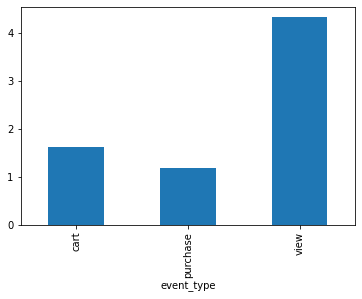

In [73]:
count_event.plot.bar()

In [74]:
del count_event

### How many times, on average, a user views a product before adding it to the cart? (dynamic)

To solve this task, the idea is to group the dataset's tuples by the user and the product and to count all the views that have a date (`event_time`) less than the one of cart's events.
First of all, we select all the tuples in our dataset that have `event_type` attribute equal to *cart*, doing the same for `event_type` equal to *view*. 

In [62]:
cart_op = dataset[dataset.event_type == 'cart'][['user_id', 'product_id', 'event_type', 'event_time']]

In [63]:
view_op = dataset[dataset.event_type == 'view'][['user_id', 'product_id', 'event_type', 'event_time']]

This way, we are able to join `cart_op` and `view_op` on `user_id` and `product_id`.

In [66]:
joined = view_op.merge(cart_op, on=['user_id', 'product_id'], suffixes=['_view', '_cart'])

Once we have obtained tuples with the following attributes

```event_time_view, event_type_view, user_id, product_id, event_time_cart, event_type_cart```,

we can select only those which have `event_time_view` less than `event_time_cart`.

In [67]:
joined = joined[joined.event_time_view < joined.event_time_cart]

Grouping by `user_id` and `product_id` and counting the tuples, we get the mean, which is the the answer to this task.

In [69]:
joined.groupby(['user_id', 'product_id']).event_time_view.count().mean()

4.643971505946073

On average, a user views a product **~4.644 times** before adding it to the cart. This means that, on average, users may evaluate the product of interest many times before deciding to purchase it.

In [75]:
del cart_op, view_op, joined

### What’s the probability that products added once to the cart are effectively bought? (dynamic)

To solve this task, we are asked for the probability of the event E such that

    E = {"a product added once to the cart is effectively bought"}.

So, we select the rows that have `event_type` equal to *cart* or to *purchase*. Then, we perform a left join between the two sets. This way, we obtain a new set of tuples in which we have *cart-purchase* rows and rows which are not coming from the *purchase* set. 

In [91]:
cart_op = dataset[dataset.event_type == 'cart'][['user_session', 'product_id', 'event_type', 'event_time']]

In [92]:
purchase_op = dataset[dataset.event_type == 'purchase'][['user_session', 'product_id', 'event_type', 'event_time']]

In [100]:
joined = cart_op.merge(purchase_op.drop_duplicates(), on=['user_session', 'product_id'], how='left', indicator=True)

Counting the *cart-purchase* rows and dividing by the total number of rows, we get the desired probability.

In [101]:
purchased = joined[joined._merge == 'both']

In [102]:
purchased.size / joined.size

0.5925371723790323

The result shows that, once customers have added an item to the cart, they bought it with a probability of about 59%, that is, more than one over two makes a purchase.

In [125]:
del cart_op, purchase_op, joined, purchased

### What’s the average time an item stays in the cart before being removed?

Because there is no attribute *removefromcart*, to find the average time an item stays in the cart before being removed, we have to consider two cases: in the first, the item is removed from cart because it is bought; in the second, the item is removed from cart because the session expires.

In [126]:
cart_op = dataset[dataset.event_type == 'cart'][['user_id', 'user_session', 'product_id', 'event_type', 'event_time']]

In [131]:
first_op_per_session = dataset.groupby(['user_id', 'user_session']).event_time.min()

In [132]:
first_op_per_session.head()

user_id    user_session                        
554748717  9333dfbd-b87a-4708-9857-6336556b0fcc   2019-10-01 00:00:00+00:00
541312140  72d76fde-8bb3-4e00-8c23-a032dfed738c   2019-10-01 00:00:00+00:00
519107250  566511c2-e2e3-422b-b695-cf8e6e792ca8   2019-10-01 00:00:01+00:00
550050854  7c90fc70-0e80-4590-96f3-13c02c18c713   2019-10-01 00:00:01+00:00
535871217  c6bd7419-2748-4c56-95b4-8cec9ff8b80d   2019-10-01 00:00:04+00:00
Name: event_time, dtype: datetime64[ns, UTC]

### How much time passes on average between the first view time and a purchase/addition to cart?

We get the first view time selecting only the rows with `event_type` equal to *view*, grouping by the `user_id` attribute and taking the minimum `event_time`, that is the minimum view date for each user. 

In [134]:
user_view = dataset[dataset.event_type == 'view'].groupby('user_id').event_time.min()

We do the same with `event_type` equal to *cart* and *purchase*. As asked in the question, we considered *cart* and *purchase* together. 

In [135]:
user_purchase_cart = dataset[(dataset.event_type == 'cart') | (dataset.event_type == 'purchase')].groupby('user_id').event_time.min()

Then, we perform a join on `user_id` between the two sets. The rows of the result that we obtain have the following format: 

    event_time_view | user_id | event_time_purchase_cart

In [137]:
joined = user_view.to_frame().merge(user_purchase_cart.to_frame(), on='user_id', suffixes=['_view', '_purchase_cart'])

Finally, we can compute the difference between `event_time_purchase_cart` and `event_time_view` and we get the average interval of time.

In [141]:
sum_deltas = 0
for t_view, t_purchase_cart in zip(joined['event_time_view'], joined['event_time_purchase_cart']):
    sum_deltas += (t_purchase_cart - t_view).total_seconds()
avg_time = (sum_deltas / joined.size) / 3600 # we convert the time from seconds to hours

In [142]:
avg_time

16.208909996121605

The average time that passes between the first view time and a purchase/addition to cart is equal to **about 16 hours and 12 minutes**.

In [143]:
del user_view, user_purchase_cart, joined

# [RQ4] How much does each brand earn per month? (dynamic)

In [116]:
def get_profit_per_month(brand_name):
    #brand_name = brand_name.strip().lower()
    brand_items = dataset[(dataset.event_type == 'purchase') & (dataset.brand == brand_name)]
    if brand_items.empty:
        return pd.DataFrame(data=[0,0], index=[10,11], columns=['profit']).rename_axis('event_time')
    result = brand_items[(brand_items.price.notna()) & (brand_items.price.notnull())].groupby(brand_items.event_time.dt.month).agg(profit=('price', 'sum'))
    if 10 not in result.index:
        result = pd.concat([result, pd.DataFrame([0,], index=[10,])])
    elif 11 not in result.index:
        result = pd.concat([result, pd.DataFrame([0,], index=[11,])])
    del brand_items
    return result

In [113]:
get_profit_per_month('samsung')

,profit
event_time,
10,2200859.56
11,1971664.55


### Is the average price of products of different brands significantly different? (dynamic)

In [38]:
dataset[dataset.brand.notna()].brand.nunique()

3130

In [5]:
dataset[['brand', 'product_id', 'price']].drop_duplicates().groupby(['brand']).price.mean().std()

268.9179481682003

### Find the top 3 brands that have suffered the biggest losses in earnings between one month and the next (dynamic)

In [114]:
brands = dataset['brand'].unique()

In [120]:
from tqdm import tqdm

diff_profit = dict.fromkeys(brands)
october, november = (10, 11)
for brand in tqdm(brands):
    profit = get_profit_per_month(brand)
    diff_profit[brand] = profit.at[november, 'profit'] - profit.at[october, 'profit']
diff_profit_list = diff_profit.items() 
diff_profit_list = sorted(diff_profit_list, key=lambda x: x[1])
diff_profit_list[:3]

100%|██████████| 3131/3131 [24:43<00:00,  2.11it/s]


[('cordiant', 24268.590000000055),
 ('michelin', 9647.399999999992),
 ('yokohama', 8410.720000000005)]

In [121]:
diff_profit = sorted(diff_profit_list, key=lambda x: x[1])

In [122]:
diff_profit_list = sorted(diff_profit_list, key=lambda x: x[1])

In [123]:
diff_profit_list[:3]

[('apple', -723815.7300001327),
 ('samsung', -229195.01000013808),
 ('huawei', -86873.56000000137)]

# [RQ7] Prove that the Pareto principle applies to your store

In [29]:
paying_customers = dataset[dataset.event_type == 'purchase'].groupby('user_id').price.agg(amount='sum').sort_values(by='amount', ascending=False)

In [5]:
n_customers = dataset.user_id.nunique()

In [6]:
n_customers

563415

In [31]:
business = paying_customers.amount.sum()
business

20638999.2

In [32]:
top_20_customers = paying_customers.head(int(0.2*n_customers)).amount.sum()

In [33]:
top_20_customers

20638999.2

In [13]:
business

20638999.2

In [14]:
paying_customers.size

45084

In [15]:
45084/563415

0.08001916881872155